In [43]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import yfinance as yf
from datetime import datetime
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 16,9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['text.color'] = 'k'

In [44]:
# Read data
data = yf.download('TM', start='2018-01-01', end='2023-01-01')
print("There are {} rows and {} columns".format(data.shape[0], data.shape[1]))
data.head()

[*********************100%***********************]  1 of 1 completed
There are 1259 rows and 6 columns


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,127.430000,128.429993,127.169998,128.369995,128.369995,83500
2018-01-03,128.679993,130.240005,128.559998,130.130005,130.130005,162200
2018-01-04,131.309998,132.160004,131.300003,132.160004,132.160004,161800
2018-01-05,133.110001,133.869995,133.080002,133.860001,133.860001,135300
2018-01-08,133.979996,134.789993,133.619995,134.770004,134.770004,131200


In [45]:
# check indexing
stock = data['Adj Close']
stock = stock.reset_index()
stock = stock.set_index('Date')

y = stock['Adj Close'].resample('MS').mean()

In [64]:
y['2022':].head()

Date
2022-01-01    199.754500
2022-02-01    191.724737
2022-03-01    171.997391
2022-04-01    172.241500
2022-05-01    163.981429
Freq: MS, Name: Adj Close, dtype: float64

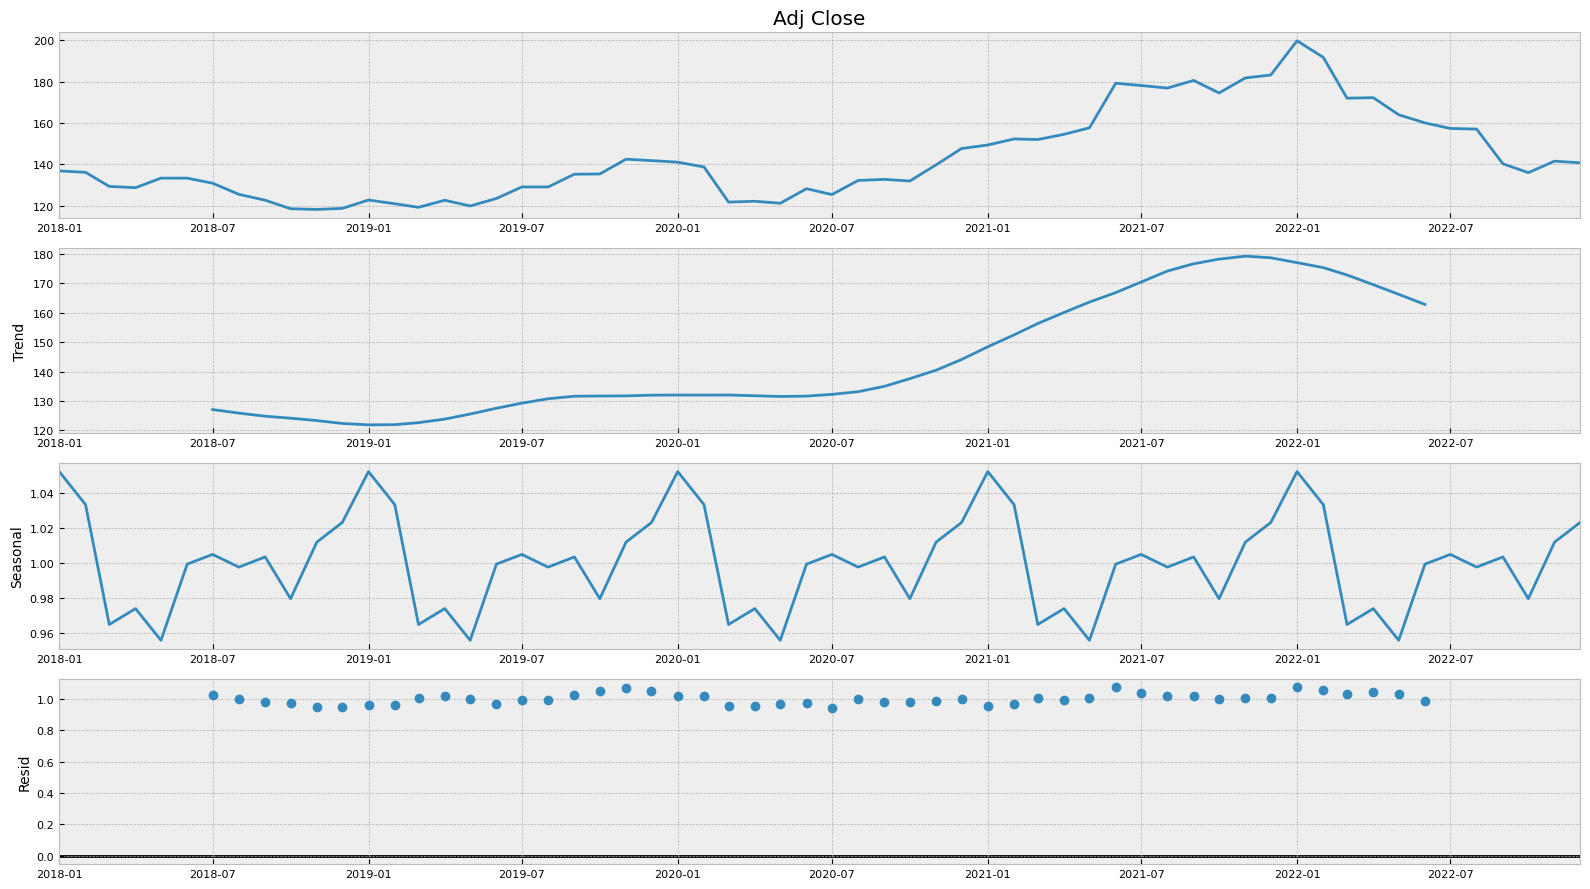

In [47]:
# seasonal_decompose to check seasonality and trend
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [81]:
# Build model parameters
p = d = q = range(1, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [82]:
for param in pdq:
    for params in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=params)
            res = mod.fit()
            print('SARIMA   {} x {}   AIC:{}'.format(param, params, res.aic))
        except:
            continue

SARIMA   (1, 1, 1) x (1, 1, 1, 12)   AIC:323.9979053857104
SARIMA   (1, 1, 1) x (1, 1, 2, 12)   AIC:325.8721783102705
SARIMA   (1, 1, 1) x (1, 2, 1, 12)   AIC:276.0695285722472
SARIMA   (1, 1, 1) x (1, 2, 2, 12)   AIC:277.70109475958634
SARIMA   (1, 1, 1) x (2, 1, 1, 12)   AIC:325.90334018986164
SARIMA   (1, 1, 1) x (2, 1, 2, 12)   AIC:327.8687216152864
SARIMA   (1, 1, 1) x (2, 2, 1, 12)   AIC:277.17746819994335
SARIMA   (1, 1, 1) x (2, 2, 2, 12)   AIC:279.1769864227752
SARIMA   (1, 1, 2) x (1, 1, 1, 12)   AIC:325.2488663650634
SARIMA   (1, 1, 2) x (1, 1, 2, 12)   AIC:327.1386456074573
SARIMA   (1, 1, 2) x (1, 2, 1, 12)   AIC:271.7212447891739
SARIMA   (1, 1, 2) x (1, 2, 2, 12)   AIC:272.5559074430217
SARIMA   (1, 1, 2) x (2, 1, 1, 12)   AIC:327.1743101225207
SARIMA   (1, 1, 2) x (2, 1, 2, 12)   AIC:329.1238264252872
SARIMA   (1, 1, 2) x (2, 2, 1, 12)   AIC:272.4642158448134
SARIMA   (1, 1, 2) x (2, 2, 2, 12)   AIC:274.4294698664619
SARIMA   (1, 2, 1) x (1, 1, 1, 12)   AIC:321.41093108

In [95]:
# Check model
model = sm.tsa.statespace.SARIMAX(y, order=(2,1,1), seasonal_order=(2,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                   60
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -156.723
Date:                            Tue, 11 Jul 2023   AIC                            327.445
Time:                                    00:16:45   BIC                            340.396
Sample:                                01-01-2018   HQIC                           332.319
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6817      0.639      1.066      0.286      -0.571       1.935
ar.L2          0.1199      0.243      0.493      0.622      -0.357       0.596
ma.L1         -0.5931      0.638     -0.930      0.353      -1.844       0.657
ar.S.L12      -0.1723      2.051     -0.084      0.933      -4.191       3.847
ar.S.L24       0.1168      1.517      0.077      0.939      -2.856       3.090
ma.S.L12      -0.9824     45.199     -0.022      0.983     -89.571      87.606
sigma2        29.7264   1285.118      0.023      0.982   -2489.058    2548.511
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.94   Prob(JB):                         0.25
Heteroskedasticity (H):               2.91   Skew:                             0.02
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

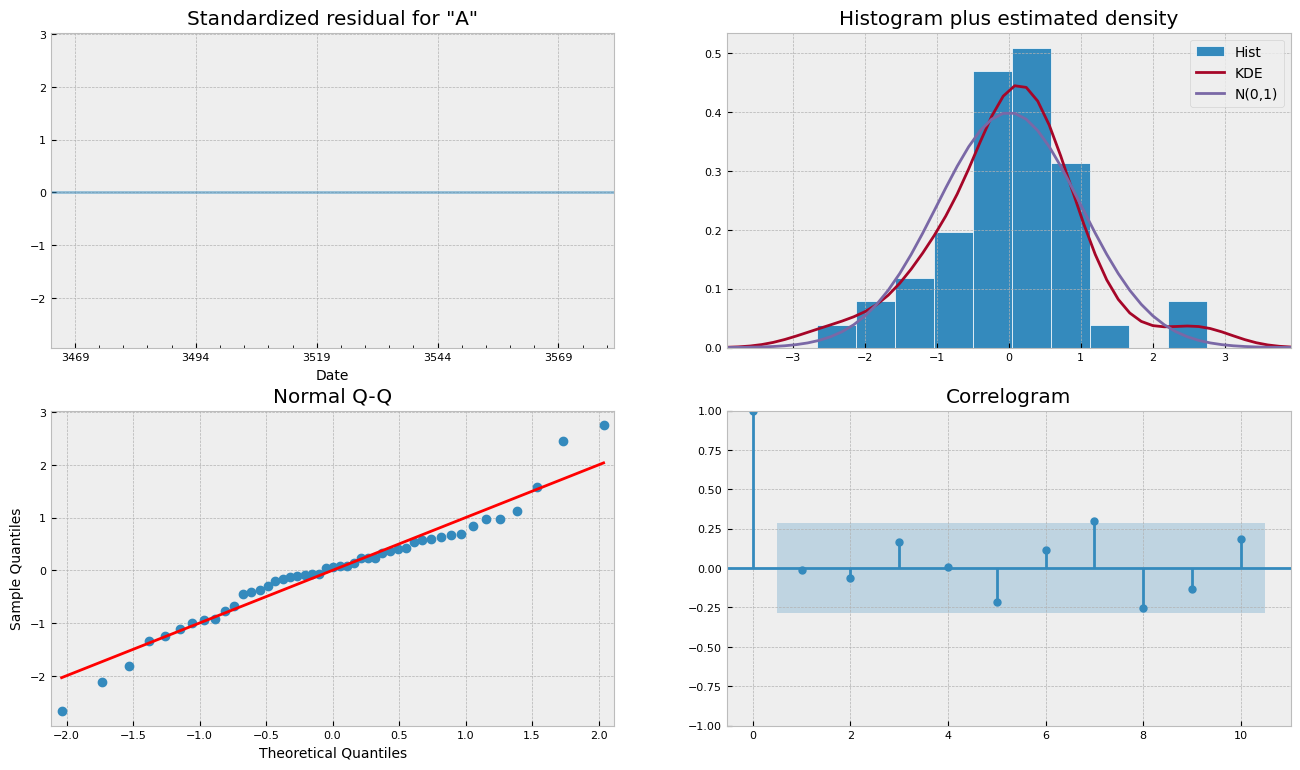

In [96]:
# Check performance
results.plot_diagnostics()
plt.show()

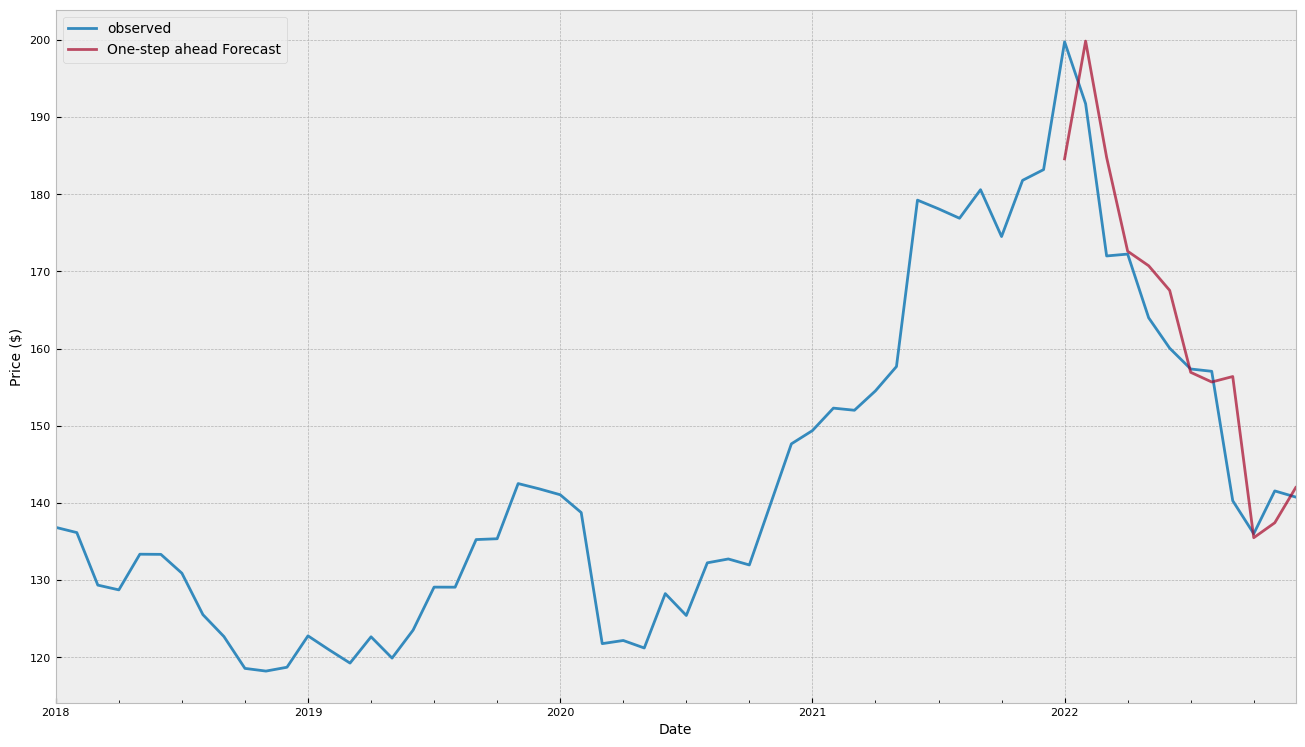

In [90]:
# Validate predictions
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)

ax = y['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
plt.legend()

plt.show()

In [91]:
# Checking forecat values using rmse metric.
y_forecasted = pred.predicted_mean
y_truth = y['2022-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 70.08
The Root Mean Squared Error of our forecasts is 8.37


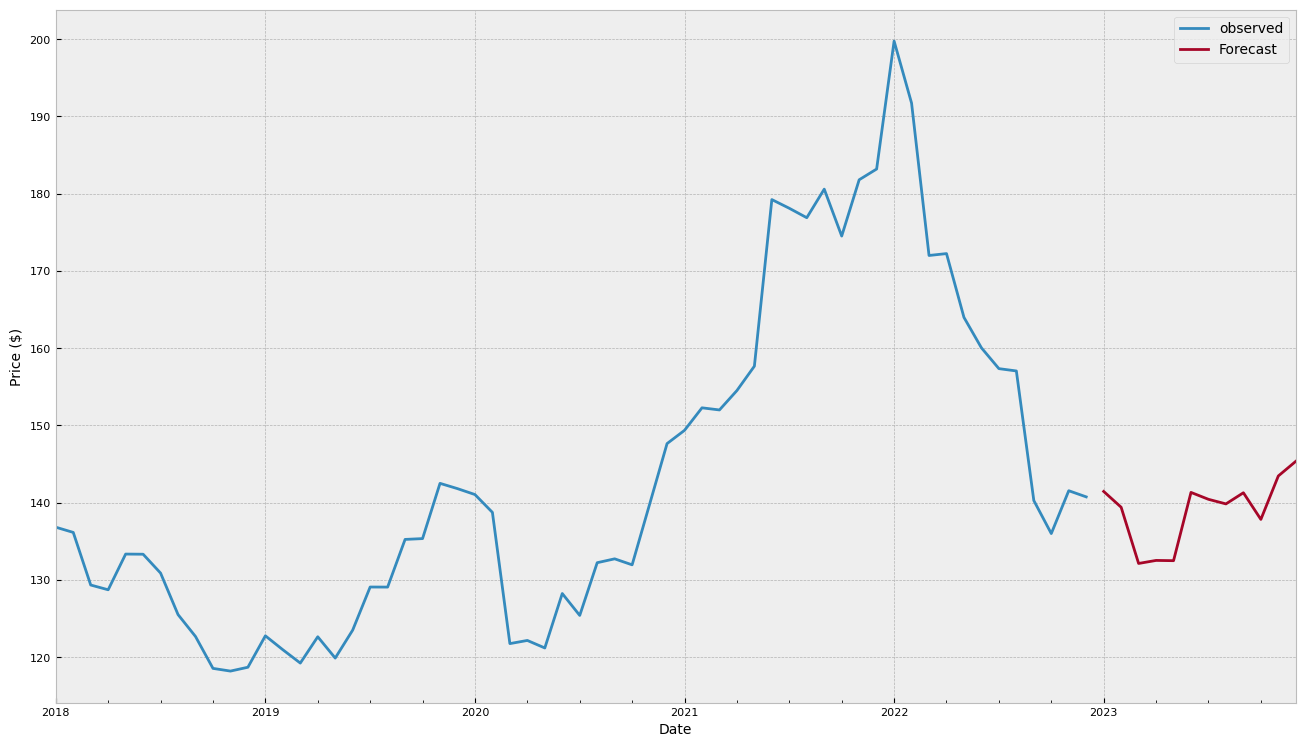

In [92]:
# plot forecasted values
pred_uc = results.get_forecast(steps=12)

ax = y.plot(label='observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

plt.legend()
plt.show()